## Plots all figures in the paper

In [1]:
base_dir = 'results/'
dir_individual = base_dir + 'individual/'
census_file = base_dir + 'pums_2019.csv'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('plots/'):
    os.makedirs('plots/')

In [3]:
from plot_utils.models import hf_models, openai_models, model_names, instruct, model_sizes

all_models = sorted(hf_models + openai_models, key=lambda x: model_sizes[x])

base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])
instruction_models = sorted(list(instruct.keys()), key=lambda x: model_sizes[x])

# due to space constrains, do not plot gptneo2.7b and llama since similar models were evaluated
plot_models = list(set(base_models) - set(['gptneo2.7b', 'llama7b', 'llama13b', 'llama65b']))
plot_models = sorted(plot_models, key=lambda x: model_sizes[x])

### Load responses

In [4]:
from plot_utils.plot_utils import acs_categories as n_categories
from plot_utils.plot_utils import load_acs_census_responses
from surveying_llms.load_responses import load_naive_responses, load_adjusted_responses

variables = list(n_categories.keys())
uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
census_responses = load_acs_census_responses(census_file, n_categories)
naive_responses = load_naive_responses(dir_individual, all_models, n_categories, openai_models)
choice_responses, adjusted_responses = load_adjusted_responses(dir_individual, all_models, 
                                                               n_categories, openai_models)

Loading naive responses...


100%|██████████| 43/43 [00:00<00:00, 502.13it/s]


Loading adjusted responses...


100%|██████████| 43/43 [00:02<00:00, 17.36it/s]


In [5]:
from plot_utils.plot_utils import compute_entropy, compute_kl

uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}
census_norm_entropies = {v: compute_entropy(census_responses[v]) / uniform_entropies[v] for v in variables}
naive_norm_entropies = {v: {m: compute_entropy(naive_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}
adjusted_norm_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}

kl_uniform_census = {v: compute_kl(uniform_responses[v], census_responses[v]) for v in variables}
adjusted_kl_census = {v: {m: compute_kl(adjusted_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}
naive_kl_census = {v: {m: compute_kl(naive_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}

In [6]:
naive_responses = load_naive_responses(dir_individual, all_models, n_categories, openai_models)

kl_unadj_census = {v: {m: compute_kl(naive_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}

Loading naive responses...


100%|██████████| 43/43 [00:00<00:00, 766.09it/s]


### Figures 2a and 2b

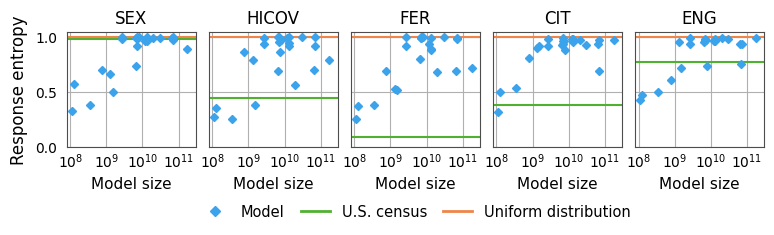

In [7]:
from plot_utils.plot_utils import figure_1
figure_1(naive_norm_entropies, census_norm_entropies, base_models, model_sizes)
plt.savefig('plots/naive_sex_fer-2.pdf', bbox_inches='tight')

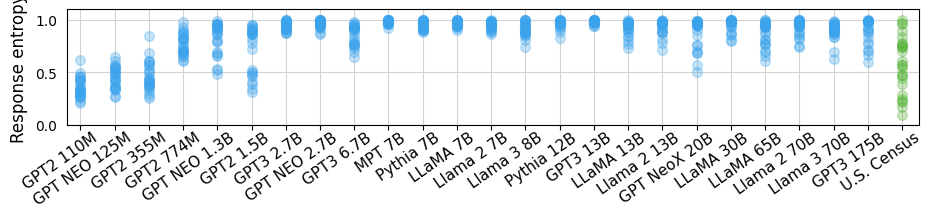

In [8]:
from plot_utils.plot_utils import plot_adjusted_entropy
plot_adjusted_entropy(naive_norm_entropies, census_norm_entropies, 
                      base_models, variables, model_names, figsize=(11, 1.5), alpha=0.3, fontsize=11, ylegend=1.28)
plt.savefig('plots/unadjusted_entropy.pdf', bbox_inches='tight')

### Figure 3

In [9]:
# remove some uninteresting models due to space constraints
to_remove = {'mpt-chat', 'vicuna13b', 'koala13b', 'vicuna7b', 'koala7b', 'mpt-instruct'}
all_models_abias = [model for model in all_models if model not in to_remove]

In [10]:
a_bias = {m: [choice_responses[v][m][0] - (1. / n_categories[v]) for v in variables] for m in all_models}
a_bias['alwaysA'] = [1. - (1. / n_categories[v]) for v in variables]
a_bias['neverA'] = [0. - (1. / n_categories[v]) for v in variables]
model_names_A = {'alwaysA': 'Always A', 'neverA': 'Never A', **model_names}

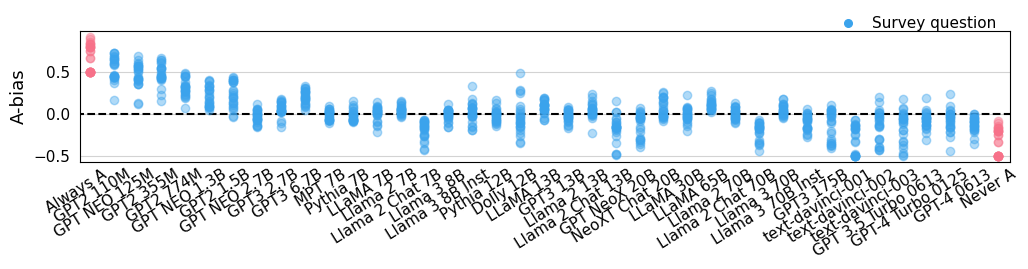

In [11]:
from plot_utils.plot_utils import plot_a_bias

plot_a_bias(a_bias, ['alwaysA'] + all_models_abias + ['neverA'], model_names_A, figsize=(12, 1.7), legendy=1.22, fontsize=11)
plt.plot([-10, 100], [0, 0], 'k--', zorder=1, linewidth=1.5)
plt.savefig('plots/a_bias.pdf', bbox_inches='tight')

### Figure 4

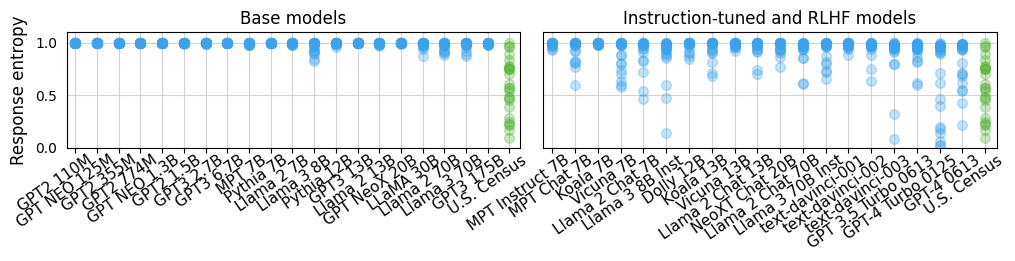

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 1.5), sharey=True)

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies, 
                      plot_models, variables, model_names, figsize=(9, 1.5), ylegend=1.3, alpha=0.3, fontsize=11, fig_ax=(fig,axs[0]))
plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies,
                      instruction_models, variables, model_names, figsize=(9, 1.5), ylegend=1.3, alpha=0.3, fontsize=11, fig_ax=(fig,axs[1]))


axs[1].set_ylabel('')
axs[0].set_title('Base models')
axs[1].set_title('Instruction-tuned and RLHF models')

plt.subplots_adjust(wspace=0.05)  # Adjust values as needed
plt.savefig('plots/adjusted_entropy.pdf', bbox_inches='tight')

### Figure 5

In [13]:
frac = {m: 0 for m in all_models}
for m in all_models:
    for v in variables:
        if adjusted_kl_uniform[v][m] >= adjusted_kl_census[v][m]:
            frac[m] += 1
frac = {k: v / len(variables) for k, v in frac.items()}
print('Largest fraction of questions closer to census than to uniform: %.2f' % (max(frac.values())))

Largest fraction of questions closer to census than to uniform: 0.24


In [14]:
from plot_utils.plot_utils import load_acs_state_responses
states, responses_states = load_acs_state_responses(census_file, n_categories)

# calculate divergence between adjusted responses and each state
subgroup_kls = {}
subgroup_kls_unadj = {}
for m in all_models:
    subgroup_kls[m] = {s: {v: compute_kl(adjusted_responses[v][m], responses_states[v][s]) 
                           for v in variables} for s in states}
    subgroup_kls_unadj[m] = {s: {v: compute_kl(naive_responses[v][m], responses_states[v][s]) 
                           for v in variables} for s in states}
    
# Do not consider ESR and JWTRNS since they contain choices with zero frequency for some of the states
variables_used = list(set(variables) - {'ESR', 'JWTRNS'})
divergence = {m: {s: np.mean([subgroup_kls[m][s][v] for v in variables_used])
                  for s in states} for m in all_models}
divergence_unadj =  {m: {s: np.mean([subgroup_kls_unadj[m][s][v] for v in variables_used])
                  for s in states} for m in all_models}

divergence_uniform = {m: np.mean([compute_kl(adjusted_responses[v][m], uniform_responses[v])
                                  for v in variables_used]) for m in all_models}
divergence_census = {m: np.mean([adjusted_kl_census[v][m] for v in variables_used]) for m in all_models}

Loading ACS responses by state...


100%|██████████| 50/50 [00:02<00:00, 23.41it/s]
/Users/rdo/Desktop/surveying-language-models/plot_utils/plot_utils.py:41: RuntimeWarning: divide by zero encountered in divide
  return np.sum(pnz * np.log2(pnz / qnz))


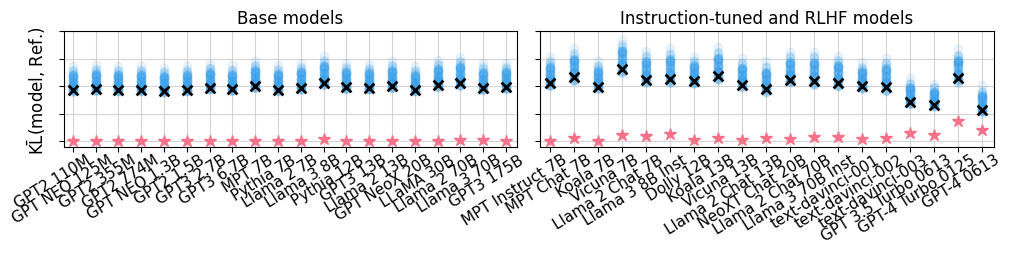

In [15]:
from plot_utils.plot_utils import plot_divergence_subgroups

fig, axs = plt.subplots(1, 2, figsize=(12, 1.5), sharey=True)

plot_divergence_subgroups(divergence, divergence_uniform, divergence_census, plot_models, model_names, 
                          figsize=(7.5, 1.5), fontsize=11, fig_ax=(fig, axs[0]))
plot_divergence_subgroups(divergence, divergence_uniform, divergence_census, instruction_models, model_names, 
                          figsize=(7, 1.5), fontsize=11, fig_ax=(fig, axs[1]))

axs[1].set_ylabel('')
axs[0].set_title('Base models')
axs[1].set_title('Instruction-tuned and RLHF models')

plt.subplots_adjust(wspace=0.05)  # Adjust values as needed

axs[1].set_yticklabels([])
axs[0].set_ylim(-0.1, 2)

plt.savefig('plots/adjusted_kl_subgroups_base.pdf', bbox_inches='tight')

### Figure 6

In [16]:
from plot_utils.plot_utils import alignment_entropy_plot

subgroup_ent = {s: np.mean([compute_entropy(responses_states[v][s]) /  uniform_entropies[v] 
                          for v in variables]) for s in states}

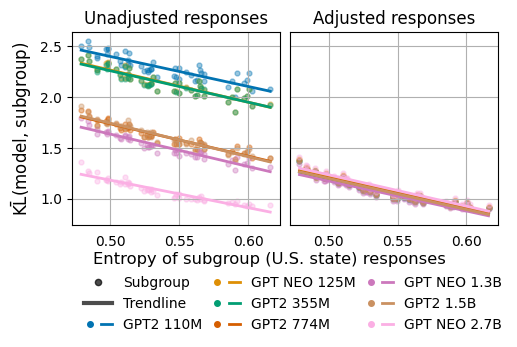

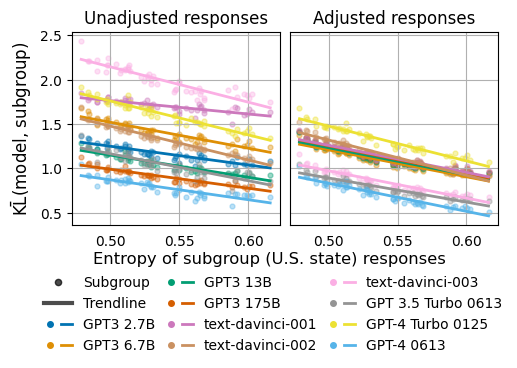

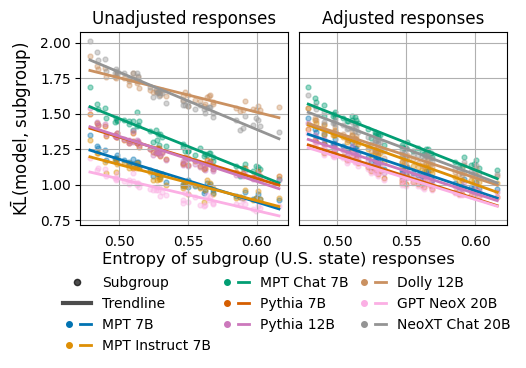

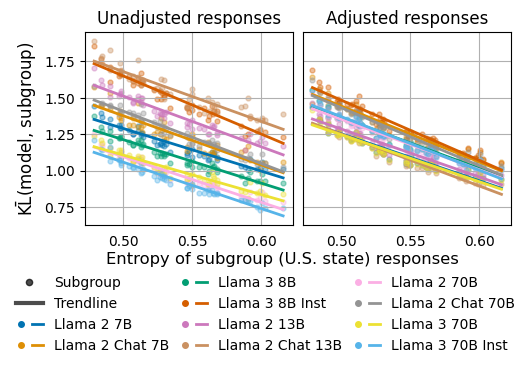

In [17]:
alingment_plot_models = {
    'lin-trend-gpt2': [
         'gpt2',
        'gptneo125m',
        'gpt2m',
        'gpt2l',
        'gptneo1.3b',
        'gpt2xl',
        'gptneo2.7b',
    ],
    'lin-trend-openai': [
         'ada',
        'babbage',
        'curie',
        'davinci',
        'text-davinci-001',
        'text-davinci-002',
        'text-davinci-003',
        'gpt-3.5-turbo',
        'gpt-4-turbo-preview',
        'gpt-4',
    ],
    'lin-trend-misc': [
         'mpt',
        'mpt-instruct',
        'mpt-chat',
        'pythia7',
        'pythia12',
        'dolly12b',
        'gptneox',
        'gptneoxchat',
    ],
    'lin-trend-llama': [
         'llama2-7b',
        'llama2-7b-chat',
        'llama3-8b',
        'llama3-8b-instruct',
        'llama2-13b',
        'llama2-13b-chat',
        'llama2-70b',
        'llama2-70b-chat',
        'llama3-70b',
        'llama3-70b-instruct'
    ]
}

for plot_name, plot_models in alingment_plot_models.items():
    alignment_entropy_plot(divergence, divergence_unadj, plot_models, states, subgroup_ent, model_names)
    plt.savefig(f'plots/{plot_name}.pdf', bbox_inches='tight')

### Figure 7

For Figure 7, please check the notebooks in `survey-ablations/`